In [8]:
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.evaluation import *

from decode_fish.funcs.visualization import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

import h5py
from decode_fish.funcs.routines import *

initialize(config_path="../config")

ValueError: GlobalHydra is already initialized, call GlobalHydra.instance().clear() if you want to re-initialize

In [11]:
base_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/'

In [37]:
img_nrs = [150,151,47]

means = [load_tiff_image(base_dir + f'/aligned_scaled2_images{nr}.tif').mean(-1).mean(-1) for nr in img_nrs]

In [12]:
vol_stack = load_tiff_image(base_dir + f'/aligned_images150.tif')

In [13]:
vol_stack.shape

torch.Size([40, 7, 2048, 2048])

In [13]:
[means[i][:22].mean() for i in range(len(img_nrs))]

[tensor(2233.3396), tensor(2416.6062), tensor(3495.0559)]

In [38]:
[means[i][:22].mean() for i in range(len(img_nrs))]

[tensor(2233.3398), tensor(2416.6064), tensor(3495.0559)]

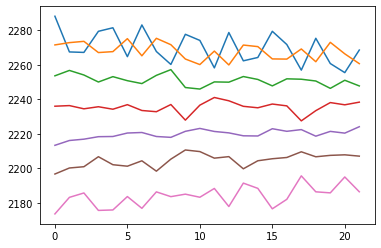

In [39]:
plt.plot(means[0])

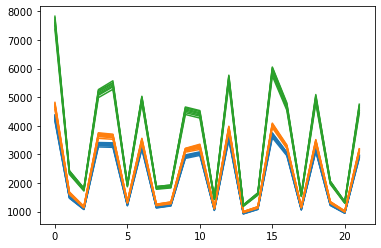

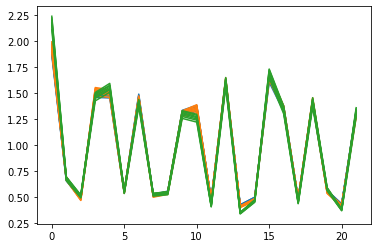

In [8]:
import seaborn as sns
cmap = sns.color_palette("tab10")

for i in range(len(means)):
    for k in range(7):
        plt.plot(means[i][:22,k], color=cmap[i])
plt.show()

for i in range(len(means)):
    for k in range(7):
        plt.plot(means[i][:22,k]/means[i][:22].mean(), color=cmap[i])

In [32]:
import tifffile
def rescale_MOp_tiffstack_by_mean(base_dir, inp_file, out_file, out_mean):
    
    vol_stack = cpu(load_tiff_image(base_dir + inp_file))
    ch_means = vol_stack.mean(-1).mean(-1).mean(-1)[:22]
    
    scaled_vol = vol_stack[:22] / ch_means[:,None,None,None] * ch_means.mean()#out_mean
    
    tifffile.imsave(base_dir + out_file, scaled_vol)

In [20]:
vol_stack.permute

<function Tensor.permute>

In [30]:
from decode_fish.funcs.dataset import GaussianSmoothing
from scipy import stats
import tifffile
def rescale_MOp_tiffstack_by_theta(base_dir, inp_file, out_file):

    vol_stack = cpu(load_tiff_image(base_dir + inp_file))
    img_5d = torch.tensor(vol_stack[:22][None]).permute([2,1,0,3,4])
    print(img_5d.shape)
    
    thetas = np.zeros(img_5d.shape[:2])
    smoother = GaussianSmoothing(smoothing_filter_size=9)

    for i in tqdm(range(len(img_5d))):
        mask = 1 - get_roi_mask(img_5d[i], pool_size=(10,10,10), percentile=50)
        for c in range(img_5d.shape[1]):

            bg_est = smoother(img_5d[i][c,:,:,:].to('cuda'))
            theta = estimate_noise_scale(img_5d[i][c][mask.nonzero()], bg_est[mask.nonzero()], percentile=98, plot=False)

            thetas[i,c] = theta

    ch_facs = 1/thetas.mean(0)
    ch_facs /= ch_facs.mean()
    
    scaled_vol = vol_stack[:22] * ch_facs[:,None,None,None]
    
    tifffile.imsave(base_dir + out_file, scaled_vol)

In [31]:
for nr in [150,151,47]:
    rescale_MOp_tiffstack_by_theta(base_dir, f'/aligned_images{nr}.tif', f'/aligned_scaled3_images{nr}.tif')

torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:38<00:00,  5.44s/it]


torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.99s/it]


torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:48<00:00,  6.98s/it]


In [25]:
# from decode_fish.funcs.exp_specific import read_MOp_tiff
# tra = read_MOp_tiff(base_dir + '/aligned_scaled_images150.tif')